In [15]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/result.csv', parse_dates=['time'], index_col=['time'])
data

,outdoor_temp,zone_temp,occupancy,supply_temp,air_flow
time,,,,,
2017-01-01 00:00:00,2.200,22.832449,0,25.000003,0.733767
2017-01-01 00:05:00,1.825,22.824465,0,25.000003,0.733767
2017-01-01 00:10:00,1.450,22.812760,0,25.000003,0.733767
2017-01-01 00:15:00,1.075,22.799019,0,25.000003,0.733767
2017-01-01 00:20:00,0.700,22.784421,0,25.000003,0.733767
...,...,...,...,...,...
2017-12-31 23:40:00,6.000,22.990503,0,25.000004,0.733767
2017-12-31 23:45:00,6.000,22.988552,0,25.000004,0.733767
2017-12-31 23:50:00,6.000,22.986715,0,25.000004,0.733767


In [19]:
train_data = data.loc['2017-07-04 07:00:00':'2017-07-04 09:00:00']
test_data = data.loc['2017-04-07 08:35:00':'2017-04-07 09:30:00']

# Data Visualization

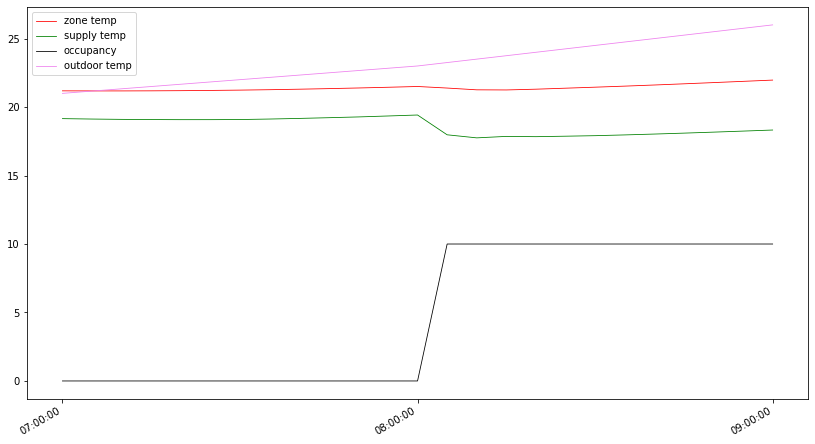

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(train_data.index, train_data['zone_temp'].values, color = 'red', linewidth = 0.8, label = 'zone temp')
#ax.plot(train_data.index, train_data['zone_temp'].values * 1.3, color = 'brown', linewidth = 0.8, label = 'true zone temp')
ax.plot(train_data.index, train_data['supply_temp'].values, color = 'green', linewidth = 0.8, label = 'supply temp')
ax.plot(train_data.index, train_data['occupancy'].values, color = 'black', linewidth = 0.8, label = 'occupancy')
ax.plot(train_data.index, train_data['outdoor_temp'].values, color = 'violet', linewidth = 0.8, label = 'outdoor temp')
#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.legend()
plt.show()

<AxesSubplot:>

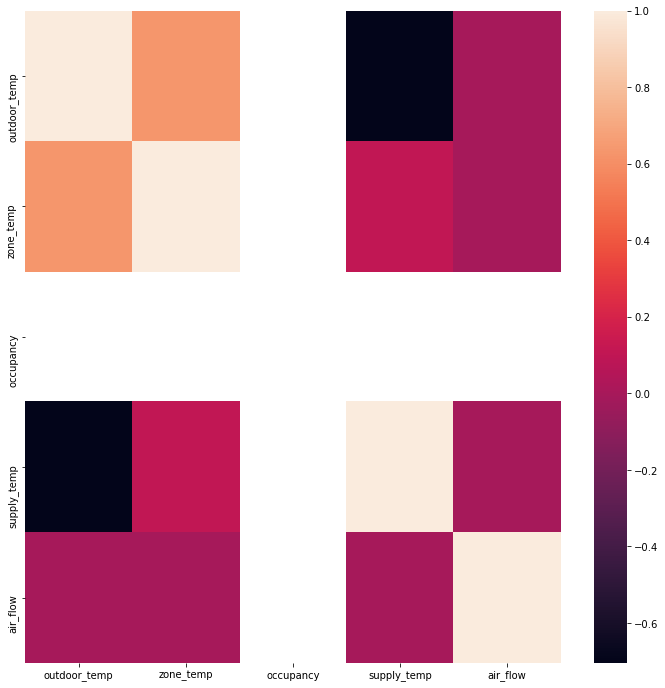

In [8]:
import seaborn as sns
plt.figure(figsize=(12,12))
sns.heatmap(train_data.corr())

# Data Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler

x_train = train_data[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
y_train = train_data[['zone_temp']]

x_test = test_data[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
y_test = test_data[['zone_temp']]


scaler = MinMaxScaler().fit(x_train)

x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

# Linear Regression

In [10]:
import statsmodels.api as sm

model = sm.OLS(y_train, x_train_norm)
results = model.fit()
results.summary()

/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              zone_temp   R-squared (uncentered):                   0.953
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              171.3
Date:                Mon, 29 Mar 2021   Prob (F-statistic):                    5.43e-12
Time:                        15:28:53   Log-Likelihood:                         -55.938
No. Observations:                  19   AIC:                                      115.9
Df Residuals:                      17   BIC:                                      117.8
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            19.4963      2.288      8.521      0.000      14.669      24.324
const               0          0        nan        nan           0           0
x2            19.0430      2.160      8.815      0.000      14.485      23.601
x3                  0          0        nan        nan           0           0
==============================================================================
Omnibus:                       15.865   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.429
Skew:                          -1.763   Prob(JB):                     0.000736
Kurtosis:                       5.408   Cond. No.                          inf
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is      0. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [11]:
pred = results.predict(x_test_norm)
print(pred)
print(y_test)

[38.56107448 36.39615064 37.03480461 36.56521911 36.38438332 36.47909163
 36.82786174 37.39186598 38.19233331 39.19629145 40.4017988  41.80244106]
                     zone_temp
time                          
2017-07-14 08:35:00  21.450669
2017-07-14 08:40:00  21.494678
2017-07-14 08:45:00  21.521697
2017-07-14 08:50:00  21.541514
2017-07-14 08:55:00  21.559780
2017-07-14 09:00:00  21.579154
2017-07-14 09:05:00  21.600545
2017-07-14 09:10:00  21.624091
2017-07-14 09:15:00  21.649976
2017-07-14 09:20:00  21.678258
2017-07-14 09:25:00  21.708965
2017-07-14 09:30:00  21.742116


In [12]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred, squared = False)

16.421096028422497

In [13]:
bounds = y_test.copy()
bounds['pred'] = pred


In [14]:
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
regressor = SVR()
model = regressor.fit(x_train, y_train)
y_pred = model.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)
print('y_test: ',y_test.zone_temp.values)
print('y_pred: ',y_pred)

0.39752599725824833
y_test:  [21.45066933 21.4946783  21.5216967  21.54151382 21.55977994 21.57915412
 21.600545   21.62409098 21.64997557 21.67825832 21.70896541 21.7421159 ]
y_pred:  [21.20433261 21.20476906 21.20531671 21.20581911 21.20633187 21.20685426
 21.20738523 21.20792302 21.20846827 21.20901946 21.20957628 21.21013825]


/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


# Actual values vs Predicted values (Linear Regression)

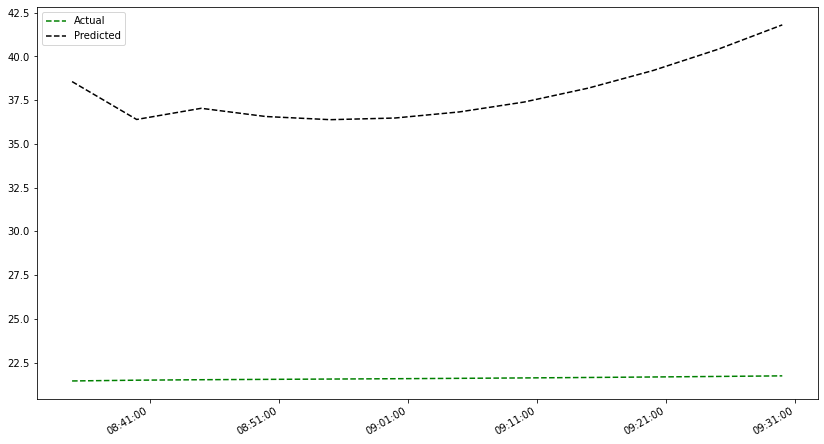

In [15]:
fig, ax = plt.subplots()
hours = mdates.MinuteLocator(interval = 10)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['zone_temp'].values, '--', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, '--', color = 'black', label = 'Predicted')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
#plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.legend()
plt.show()

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(random_state=0).fit(x_train_norm, y_train)
gpr.score(x_train_norm, y_train)

pred = gpr.predict(x_test_norm, return_std=True)
# print(pred)
# print(y_test)

In [17]:
mean_squared_error(y_test, pred[0],squared = False)

0.609723558669909

In [18]:
bounds = y_test.copy()
bounds['pred'] = pred[0]
bounds

,zone_temp,pred
time,,
2017-07-14 08:35:00,21.450669,21.446021
2017-07-14 08:40:00,21.494678,21.370408
2017-07-14 08:45:00,21.521697,21.341074
2017-07-14 08:50:00,21.541514,21.298464
2017-07-14 08:55:00,21.559780,21.256868
2017-07-14 09:00:00,21.579154,21.209960
2017-07-14 09:05:00,21.600545,21.151994
2017-07-14 09:10:00,21.624091,21.078134
2017-07-14 09:15:00,21.649976,20.982528


# Actual values vs Predicted values (Gaussain Process Regression)

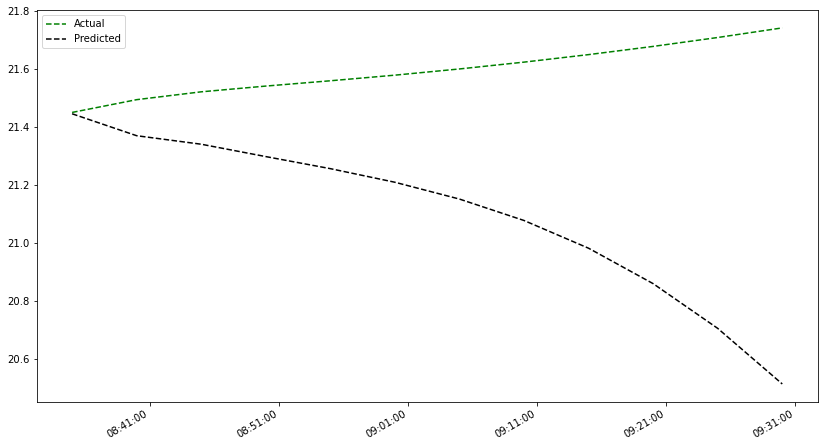

In [19]:
fig, ax = plt.subplots()
hours = mdates.MinuteLocator(interval = 10)
h_fmt = mdates.DateFormatter('%H:%M:%S')

ax.plot(bounds.index, bounds['zone_temp'].values, '--', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, '--', color = 'black', label = 'Predicted')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
#plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.legend()
plt.show()

# Sample set up for Model precision feedback

In [20]:
from sklearn.model_selection import train_test_split

## loading dataset and initializations
#train = pd.read_csv('data/train_test/train2.csv')
#test = pd.read_csv('data/train_test/test2.csv')
#non_date_data = pd.read_csv('data/result.csv')
train = data.loc['2017-07-14 07:00:00':'2017-07-14 08:30:00']
test = data.loc['2017-07-14 08:35:00':'2017-07-14 09:30:00']
#train = data.loc['2017-06-01 07:45:00':'2017-06-01 08:45:00']
#print(train)
#train = train.set_index(pd.Index(range(0,13)),'time')
#print(train)
#test = data.loc['2017-06-01 08:50:00':'2017-06-01 09:20:00']
#test = test.set_index(pd.Index(range(0,7)),'time')
filtered_data = train[['supply_temp', 'air_flow','outdoor_temp','occupancy', 'zone_temp']]
err = 100000
end_index = 5
kernel = DotProduct() + WhiteKernel()

##Epochs configuration for the semi-active learning

while err > 0.5 and end_index < len(train):
    zone_data = filtered_data[0:end_index+1]
    X = zone_data[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
    Y = zone_data[['zone_temp']]
    #print(X)
    
    X1 = test[['supply_temp', 'air_flow','outdoor_temp','occupancy']]
    Y1 = test[['zone_temp']]
    
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    X1_norm = scaler.transform(X1)
    
    #x_train, x_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.50)
    regressor = SVR()
    svr_model = regressor.fit(x_train, y_train)
    #gpr = GaussianProcessRegressor().fit(X_norm, Y)
    #ols = sm.OLS(Y, X_norm)
    #model_linear = ols.fit()
    
    #pred = gpr.predict(x_test, return_std=True)
    #pred1 = gpr.predict(X1_norm, return_std=True)
    #pred_linear_model = model_linear.predict(X1_norm)
    pred_svr_model = svr_model.predict(X1_norm)
    
    temp_error = mean_squared_error(Y1, pred_svr_model, squared = False) #For Gaussian Process
    #temp_error = mean_squared_error(Y1, pred_linear_model, squared = False) #For Linear Regression
    
    if temp_error < err:
        err = temp_error
    print(err)
    end_index = end_index + 1

0.42067556347822893


/Users/devanshukumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [21]:
print(Y1)
print(pred_svr_model)

                     zone_temp
time                          
2017-07-14 08:35:00  21.450669
2017-07-14 08:40:00  21.494678
2017-07-14 08:45:00  21.521697
2017-07-14 08:50:00  21.541514
2017-07-14 08:55:00  21.559780
2017-07-14 09:00:00  21.579154
2017-07-14 09:05:00  21.600545
2017-07-14 09:10:00  21.624091
2017-07-14 09:15:00  21.649976
2017-07-14 09:20:00  21.678258
2017-07-14 09:25:00  21.708965
2017-07-14 09:30:00  21.742116
[21.18384814 21.1842098  21.18409231 21.18417002 21.18420045 21.18418475
 21.18412572 21.18402943 21.18389124 21.18371637 21.18350451 21.1832562 ]


# DataFrame setup for Post validation

In [22]:
upper_bound = []
lower_bound = []

upper_bound = pred_svr_model + 0.5 + 0.59
lower_bound = pred_svr_model - 0.5 - 0.59
bounds = Y1.copy()
temp = pd.date_range(start='2017-07-04 08:35:00', periods=12, freq='300s')
bounds['date'] = temp
bounds['upper'] = upper_bound
bounds['lower'] = lower_bound
#bounds['zone_temp'] = bounds['zone_temp'] + 6
bounds['upper_BMS'] = Y1['zone_temp'] + 0.25 + 0.59
bounds['lower_BMS'] = Y1['zone_temp'] - 0.25 - 0.59
bounds['pred'] = pred_svr_model
bounds.set_index('date',inplace=True)
bounds

,zone_temp,upper,lower,upper_BMS,lower_BMS,pred
date,,,,,,
2017-07-04 08:35:00,21.450669,22.273848,20.093848,22.290669,20.610669,21.183848
2017-07-04 08:40:00,21.494678,22.274210,20.094210,22.334678,20.654678,21.184210
2017-07-04 08:45:00,21.521697,22.274092,20.094092,22.361697,20.681697,21.184092
2017-07-04 08:50:00,21.541514,22.274170,20.094170,22.381514,20.701514,21.184170
2017-07-04 08:55:00,21.559780,22.274200,20.094200,22.399780,20.719780,21.184200
2017-07-04 09:00:00,21.579154,22.274185,20.094185,22.419154,20.739154,21.184185
2017-07-04 09:05:00,21.600545,22.274126,20.094126,22.440545,20.760545,21.184126
2017-07-04 09:10:00,21.624091,22.274029,20.094029,22.464091,20.784091,21.184029
2017-07-04 09:15:00,21.649976,22.273891,20.093891,22.489976,20.809976,21.183891


# Bounds Visualization

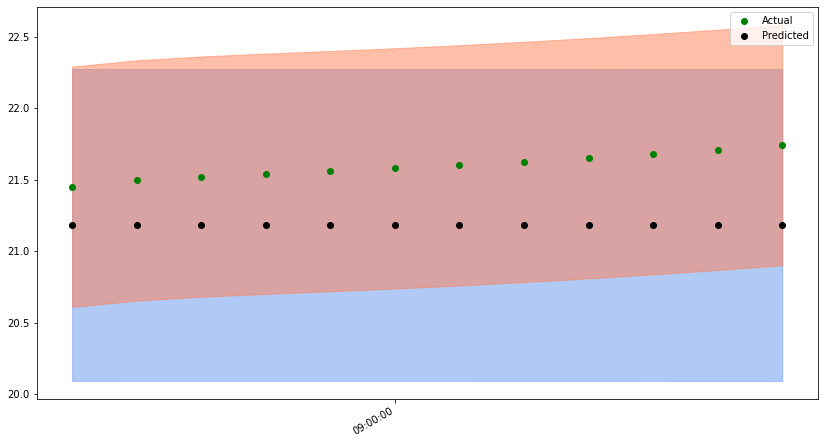

In [23]:
fig, ax = plt.subplots()
hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

#ax.plot(bounds.index, bounds['upper'].values, '--', color = 'red', label = 'Upper bound')
ax.plot(bounds.index, bounds['zone_temp'].values, 'o', color = 'green', label = 'Actual')
ax.plot(bounds.index, bounds['pred'].values, 'o', color = 'black', label = 'Predicted')
#ax.plot(bounds.index, bounds['lower'].values, '--', color = 'violet', label = 'Lower Bound')

#Then tick and format with matplotlib:
ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

fig.autofmt_xdate()
fig.set_size_inches(14, 8)
plt.fill_between(bounds.index, bounds['upper'].values,bounds['lower'].values,color='cornflowerblue',alpha=.5)
plt.fill_between(bounds.index, bounds['upper_BMS'].values,bounds['lower_BMS'].values,color='coral',alpha=.5)
plt.legend()
plt.show()